In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as ss

In [2]:
class Lookback_options:
    def __init__(self, S_0, r, sigma, T, step, K = None):
        self.S_0 = S_0 # initial stock price
        self.K = K # strike
        self.r = r # interest rate
        self.sigma = sigma # volatility
        self.T = T # maturity
        self.step = step # number of steps
        self.dt = self.T / self.step
        self.u = np.exp(self.sigma * np.sqrt(self.dt)) # upward factor for CRR approxiamtion
        self.d = 1/self.u # downward factor for CRR approxiamtion
        self.q = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d) #arbitrage probability

    def payoff_floating(self, option, S):
        if option == 'call':
            return S[-1] - np.min(S)
        if option == 'put':
            return np.max(S) - S[-1]
        
    def payoff_fixed(self, option, S):
        if option == 'call':
            return np.max(np.max(S) - self.K, 0)
        if option == 'put':
            return np.max(self.K - np.min(S), 0)

    def d1(self, S, K, t):
        return ((np.log(S / K) + (self.r + 0.5 * self.sigma ** 2) * (self.T-t))/(self.sigma * np.sqrt(self.T-t)))
    
    def d2(self, S, K, t):
        return self.d1(S, K, t) - self.sigma * np.sqrt(self.T-t)

    def price(self, option, S, t, method):
        # mini = self.S_0 * self.d ** self.step
        # maxi = self.S_0 * self.u ** self.step
        mini = S # assumption from notes
        maxi = S # assumption from notes
        if method == 'floating':
            if option == 'call':
                return S * norm.cdf(self.d1(S, mini, t)) - mini * np.exp(-self.r * (self.T-t)) * norm.cdf(self.d2(S, mini, t)) + S * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                    ((S/mini)**(-2*self.r/self.sigma**2) * norm.cdf(-self.d1(S, mini, t) + (2*self.r*np.sqrt(self.T-t))/self.sigma) - np.exp(self.r*(self.T-t))*norm.cdf(-self.d1(S, mini, t)))
            if option == 'put':
                return maxi * np.exp(-self.r * (self.T - t)) * norm.cdf(-self.d2(S, maxi, t)) - S * norm.cdf(-self.d1(S, maxi, t)) + S * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                    (-(S/maxi)**(-2*self.r/self.sigma**2) * norm.cdf(self.d1(S, maxi, t) - (2*self.r*np.sqrt(self.T-t))/self.sigma) + np.exp(self.r*(self.T-t))*norm.cdf(self.d1(S, maxi, t)))
        if method == 'fixed':
            if option == 'call':
                if self.K > maxi:
                    return S * norm.cdf(self.d1(S, self.K, t)) - self.K * np.exp(-self.r * (self.T-t)) * norm.cdf(self.d2(S, self.K, t)) + S * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                        (-(S/self.K)**(-2*self.r/self.sigma**2) * norm.cdf(self.d1(S, self.K, t) - (2*self.r*np.sqrt(self.T-t))/self.sigma) + np.exp(self.r*(self.T-t))*norm.cdf(self.d1(S, self.K, t)))
                else:
                    return (maxi - self.K) * np.exp(-self.r*(self.T-t)) + S * norm.cdf(self.d1(S, maxi, t)) - maxi * np.exp(-self.r * (self.T-t)) * norm.cdf(self.d2(S, maxi, t)) + S * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                        (-(S/maxi)**(-2*self.r/self.sigma**2) * norm.cdf(self.d1(S, maxi, t) - (2*self.r*np.sqrt(self.T-t))/self.sigma) + np.exp(self.r*(self.T-t))*norm.cdf(self.d1(S, maxi, t)))
            if option == 'put':
                if self.K < mini:
                    return self.K * np.exp(-self.r * (self.T-t)) * norm.cdf(-self.d2(S, self.K, t)) - S * norm.cdf(-self.d1(S, self.K, t)) + S * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                        ((S/self.K)**(-2*self.r/self.sigma**2) * norm.cdf(-self.d1(S, self.K, t) + (2*self.r*np.sqrt(self.T-t))/self.sigma) - np.exp(self.r*(self.T-t))*norm.cdf(-self.d1(S, self.K, t)))
                else:
                    return (self.K - mini) * np.exp(-self.r*(self.T-t)) + mini * np.exp(-self.r * (self.T-t)) * norm.cdf(-self.d2(S, mini, t)) - S * norm.cdf(-self.d1(S, mini, t)) + S * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                        ((S/mini)**(-2*self.r/self.sigma**2) * norm.cdf(-self.d1(S, mini, t) + (2*self.r*np.sqrt(self.T-t))/self.sigma) - np.exp(self.r*(self.T-t))*norm.cdf(-self.d1(S, mini, t)))

        
    def create_Cheuk_Vorst_tree(self, option_type):
        Y = [[1]]
        for i in range(self.step+1):
            Y.insert(i+1, [])
            for j in range(i+1):
                if option_type == 'put':
                    Y[i+1].append(self.u**j)
                if option_type == 'call':
                    Y[i+1].append(self.d**(i-j))      
        Y.pop(0)

        return Y
    
    def create_underlying_price_tree(self):
        underlying_price_tree = [[self.S_0]]
        for i in range(self.step):
            i_step = []
            for j in range(len(underlying_price_tree[i])):
                i_step.extend([underlying_price_tree[i][j] * self.u, underlying_price_tree[i][j] * self.d])
            underlying_price_tree.append(i_step)

        return underlying_price_tree
    
    def create_trajectories(self):
        underlying_price_tree = self.create_underlying_price_tree()
        trajectories = []
        for i in range(2**(self.step)):
            indices = []
            trajectory = []
            for k in range(self.step + 1):
                ind = i // 2**(self.step - k)
                indices.append(ind)
            for k in range(self.step + 1):
                trajectory.append(underlying_price_tree[k][indices[k]])
            trajectories.append(trajectory)
        return trajectories
    
    def create_Cheuk_Vorst_option_price_tree(self, method, option_type):
        if method == 'floating':
            Y = self.create_Cheuk_Vorst_tree(option_type)
            V = Y
            if option_type == 'put':
                for i in range(len(V[-1])):
                    V[-1][i] -= 1
                for i in range(self.step - 1, -1, -1):
                    for j in range(i+1):
                        if j == 0:
                            V[i][j] = np.exp(-self.r * self.dt) * (self.q * self.u * V[i+1][j] + (1 - self.q) * self.d * V[i+1][j+1])
                        else:    
                            V[i][j] = np.exp(-self.r * self.dt) * (self.q * self.u * V[i+1][j-1] + (1 - self.q) * self.d * V[i+1][j+1])
            if option_type == 'call':
                for i in range(len(V[-1])):
                    V[-1][i] = 1 - Y[-1][i]
                for i in range(self.step - 1, -1, -1):
                    for j in range(i+1):
                        if j + 1 > i:
                            V[i][j] = np.exp(-self.r * self.dt) * (self.q * self.u * V[i+1][j] + (1 - self.q) * self.d * V[i+1][j+1])
                        else:
                            V[i][j] = np.exp(-self.r * self.dt) * (self.q * self.u * V[i+1][j] + (1 - self.q) * self.d * V[i+1][j+2])
            return V[0][0] * self.S_0
        
        if method == 'fixed':
            if option_type == 'put':
                Y = self.create_Cheuk_Vorst_tree('call')
                X = Y
                for i in range(len(X[-1])):
                    X[-1][i] = 0
                for i in range(self.step - 1, -1, -1):
                    for j in range(i+1):
                        if j + 1 > i:
                            X[i][j] = np.exp(-self.r * self.dt) * (self.q * self.u * X[i+1][j] + (1 - self.q) * self.d * X[i+1][j+1]) + (1 - self.q) * (1 - self.d)/(np.exp(self.r * self.dt))**(self.step-i)
                        else:    
                            X[i][j] = np.exp(-self.r * self.dt) * (self.q * self.u * X[i+1][j] + (1 - self.q) * self.d * X[i+1][j+2]) 
                
            if option_type == 'call':
                Y = self.create_Cheuk_Vorst_tree('put')
                X = Y
                for i in range(len(X[-1])):
                    X[-1][i] = 0
                for i in range(self.step - 1, -1, -1):
                    for j in range(i+1):
                        if j == 0:
                            X[i][j] = np.exp(-self.r * self.dt) * (self.q * self.u * X[i+1][j] + (1 - self.q) * self.d * X[i+1][j+1]) + self.q * (self.u - 1)/(np.exp(self.r * self.dt))**(self.step-i)
                        else:    
                            X[i][j] = np.exp(-self.r * self.dt) * (self.q * self.u * X[i+1][j-1] + (1 - self.q) * self.d * X[i+1][j+1])
            
            if option_type == 'put':
                return X[0][0] * self.S_0 + (self.K - self.S_0) * np.exp(-self.r*self.T)
            if option_type == 'call':
                return X[0][0] * self.S_0 + (self.S_0 - self.K) * np.exp(-self.r*self.T)

    def create_option_price_tree(self, method, option_type, underlying_price_tree):
        trajectories = self.create_trajectories()
        option_price_tree = []
        for i in range(self.step, -1, -1):
            option_price_tree.insert(0, [])
            for j in range(len(underlying_price_tree[i])):
                if i == self.step:
                    if method == 'floating':
                        option_price_tree[0].append(self.payoff_floating(option_type, trajectories[j]))
                    if method == 'fixed':
                        option_price_tree[0].append(self.payoff_fixed(option_type, trajectories[j]))
                else:
                    option_price_tree[0].append(np.exp(-self.r * self.dt)*(self.q * option_price_tree[1][2*j] + (1 - self.q) * option_price_tree[1][2*j+1]))
        return option_price_tree[0][0]
    
    def calculate_price_Cheuk_Vorst(self, option_type, method):
        return self.create_Cheuk_Vorst_option_price_tree(method, option_type)
    
    def calculate_price(self, option_type, method):
        underlying_price_tree = self.create_underlying_price_tree()
        return self.create_option_price_tree(method, option_type, underlying_price_tree)
    
    def calculate_price_MC(self, option, method):
        payoffs = []
        for _ in range(10000):
            x = ss.binom.rvs(1, self.q, size = self.step)
            p = 2 * x - 1
            k = np.cumsum(p)
            k = np.insert(k, 0, 0)
            trajectory = self.S_0 * self.u ** k
            if method == 'floating': 
                payoffs.append(self.payoff_floating(option, trajectory))
            if method == 'fixed':
                payoffs.append(self.payoff_fixed(option, trajectory))
        
        return np.exp(-self.r * self.T) * np.mean(payoffs)

In [3]:
S0 = 100
sigma = 0.02
r = 0.05
T = 0.5
K = 100

In [4]:
steps = np.arange(4, 501, 1)
put_floating = []
call_floating = []
put_fixed = []
call_fixed = []
call_CV_floating = []
put_CV_floating = []
call_CV_fixed = []
put_CV_fixed = []
call_simulate_floating = []
put_simulate_floating = []
call_simulate_fixed = []
put_simulate_fixed = []
for step in steps:
    lb = Lookback_options(S0, r, sigma, T, step, K)
    if step <= 20:
        call_floating.append(lb.calculate_price('call', 'floating'))
        put_floating.append(lb.calculate_price('put', 'floating'))
        call_fixed.append(lb.calculate_price('call', 'fixed'))
        put_fixed.append(lb.calculate_price('put', 'fixed'))
        call_simulate_floating.append(lb.calculate_price_MC('call', 'floating'))
        put_simulate_floating.append(lb.calculate_price_MC('put', 'floating'))
        call_simulate_fixed.append(lb.calculate_price_MC('call', 'fixed'))
        put_simulate_fixed.append(lb.calculate_price_MC('put', 'fixed'))
    call_CV_floating.append(lb.calculate_price_Cheuk_Vorst('call', 'floating'))
    put_CV_floating.append(lb.calculate_price_Cheuk_Vorst('put', 'floating'))
    call_CV_fixed.append(lb.calculate_price_Cheuk_Vorst('call', 'fixed'))
    put_CV_fixed.append(lb.calculate_price_Cheuk_Vorst('put', 'fixed'))

In [5]:
bs_price_call_floating = lb.price('call', S0, 0, 'floating')
bs_price_put_floating = lb.price('put', S0, 0, 'floating')
bs_price_call_fixed = lb.price('call', S0, 0, 'fixed')
bs_price_put_fixed = lb.price('put', S0, 0, 'fixed')

1. Floating

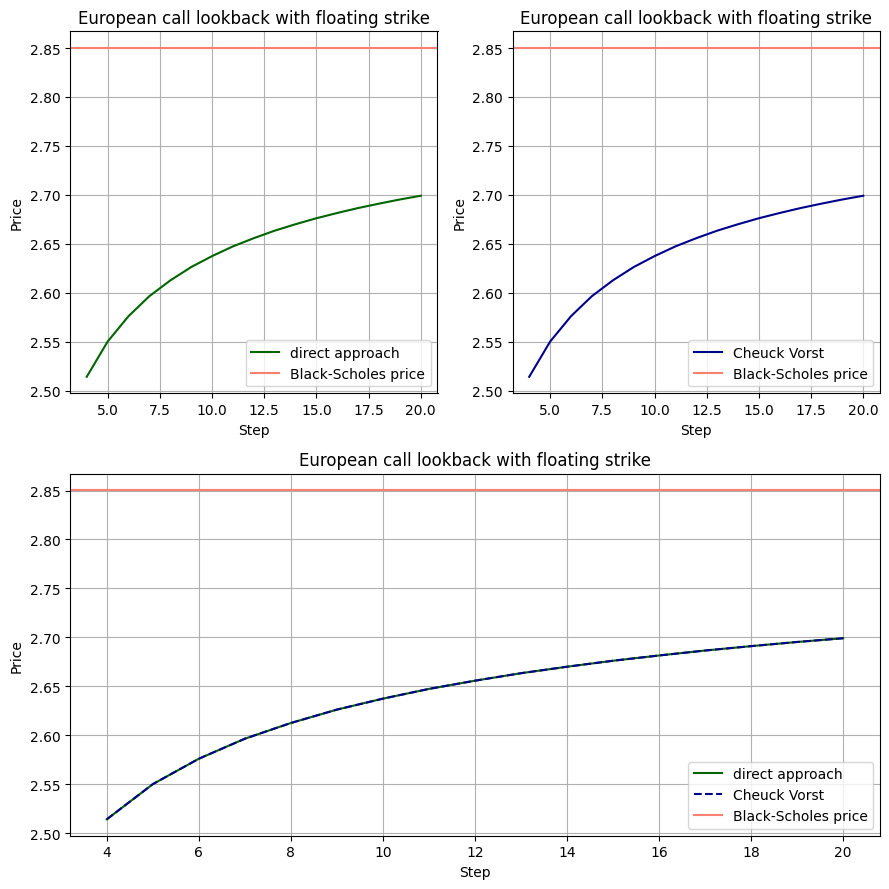

In [6]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :2])

ax1.plot(steps[:17], call_floating, label = 'direct approach', color = 'darkgreen')
ax1.axhline(bs_price_call_floating, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], call_CV_floating[:17], label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_call_floating, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax3.plot(steps[:17], call_floating, label = 'direct approach', color = 'darkgreen')
ax3.plot(steps[:17], call_CV_floating[:17], linestyle = '--', label = 'Cheuck Vorst', color = 'darkblue')
ax3.axhline(bs_price_call_floating, color = 'salmon', label = 'Black-Scholes price')
ax3.set_ylabel('Price')
ax3.set_xlabel('Step')
ax3.grid()
ax3.legend(loc = 'lower right')

ax1.set_title('European call lookback with floating strike')
ax2.set_title('European call lookback with floating strike')
ax3.set_title('European call lookback with floating strike')

plt.tight_layout()
plt.show()

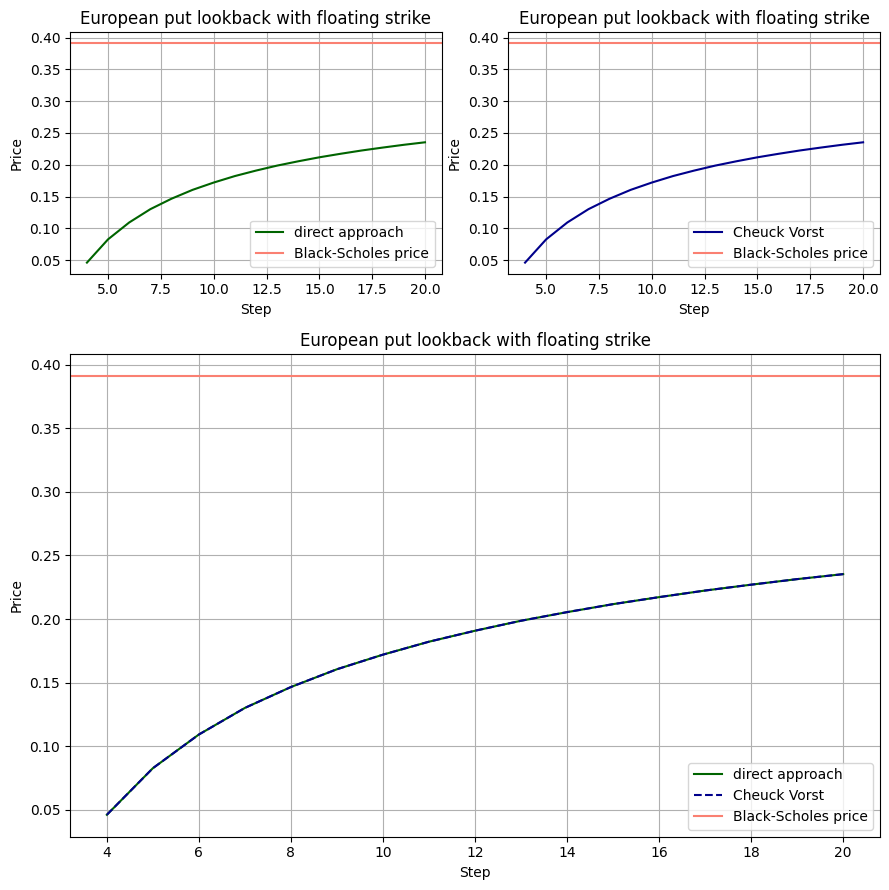

In [7]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :2])

ax1.plot(steps[:17], put_floating, label = 'direct approach', color = 'darkgreen')
ax1.axhline(bs_price_put_floating, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], put_CV_floating[:17], label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_put_floating, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax3.plot(steps[:17], put_floating, label = 'direct approach', color = 'darkgreen')
ax3.plot(steps[:17], put_CV_floating[:17], linestyle = '--', label = 'Cheuck Vorst', color = 'darkblue')
ax3.axhline(bs_price_put_floating, color = 'salmon', label = 'Black-Scholes price')
ax3.set_ylabel('Price')
ax3.set_xlabel('Step')
ax3.grid()
ax3.legend(loc = 'lower right')

ax1.set_title('European put lookback with floating strike')
ax2.set_title('European put lookback with floating strike')
ax3.set_title('European put lookback with floating strike')

plt.tight_layout()
plt.show()

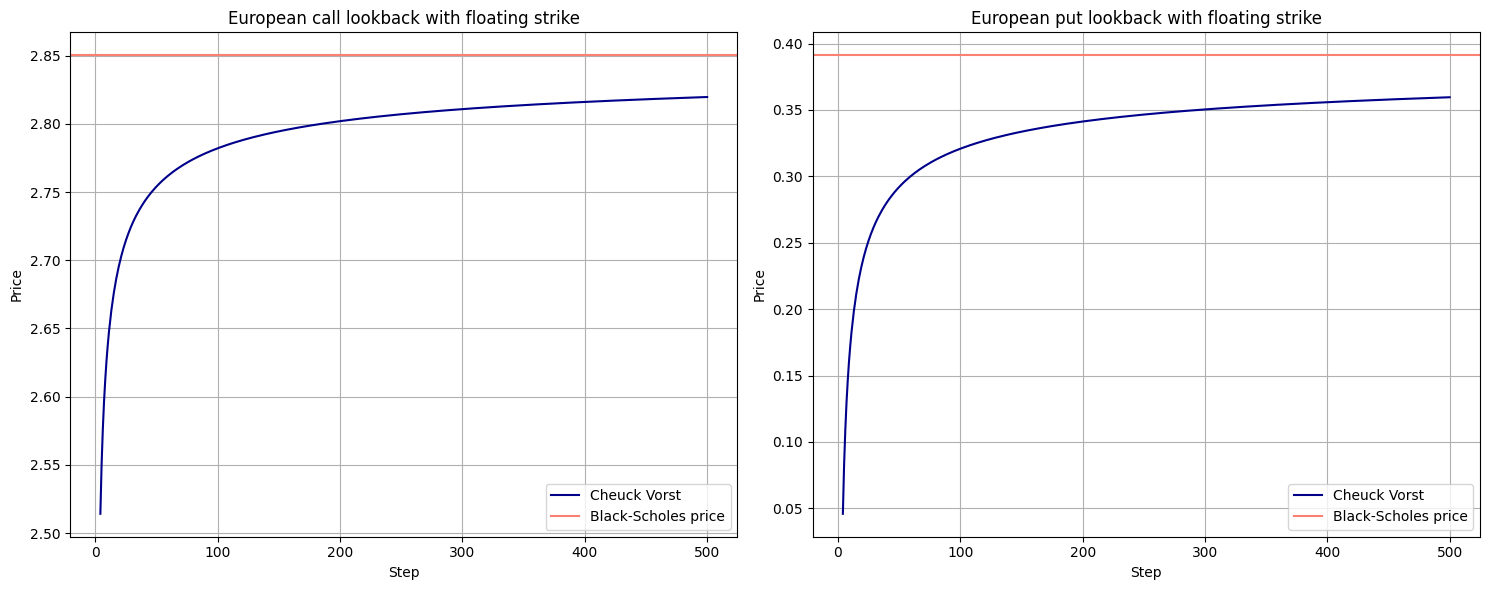

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(steps, call_CV_floating, label = 'Cheuck Vorst', color = 'darkblue')
ax1.axhline(bs_price_call_floating, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps, put_CV_floating, label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_put_floating, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax1.set_title('European call lookback with floating strike')
ax2.set_title('European put lookback with floating strike')

plt.tight_layout()
plt.show()

2. Fixed

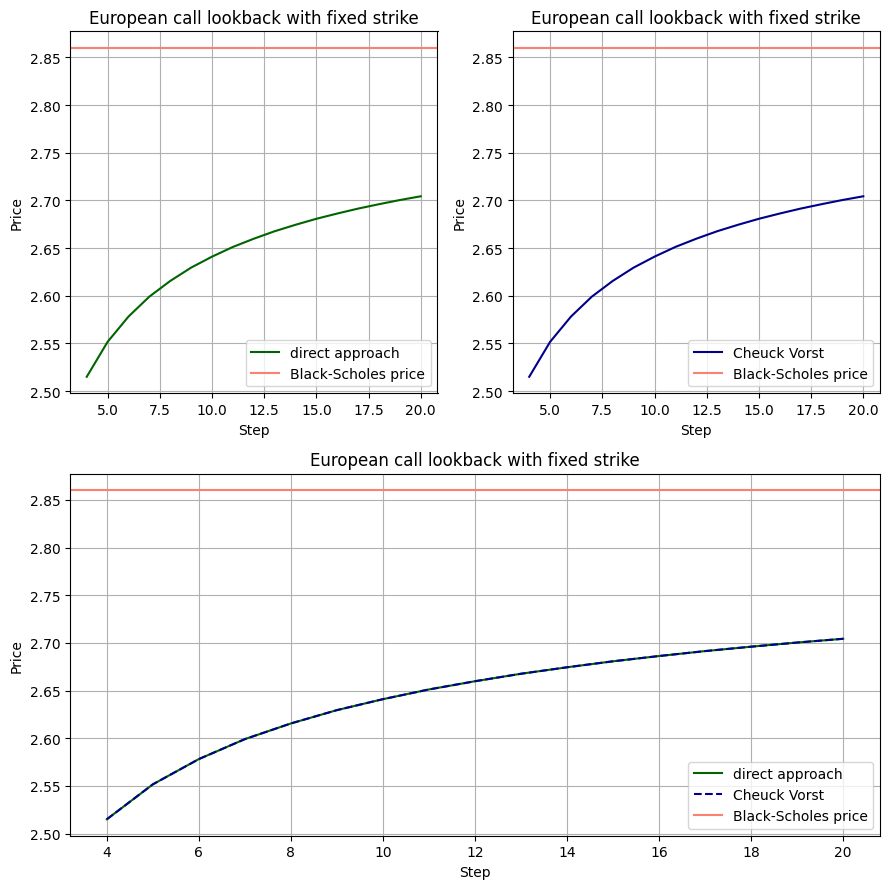

In [9]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :2])

ax1.plot(steps[:17], call_fixed, label = 'direct approach', color = 'darkgreen')
ax1.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], call_CV_fixed[:17], label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax3.plot(steps[:17], call_fixed, label = 'direct approach', color = 'darkgreen')
ax3.plot(steps[:17], call_CV_fixed[:17], linestyle = '--', label = 'Cheuck Vorst', color = 'darkblue')
ax3.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax3.set_ylabel('Price')
ax3.set_xlabel('Step')
ax3.grid()
ax3.legend(loc = 'lower right')

ax1.set_title('European call lookback with fixed strike')
ax2.set_title('European call lookback with fixed strike')
ax3.set_title('European call lookback with fixed strike')

plt.tight_layout()
plt.show()

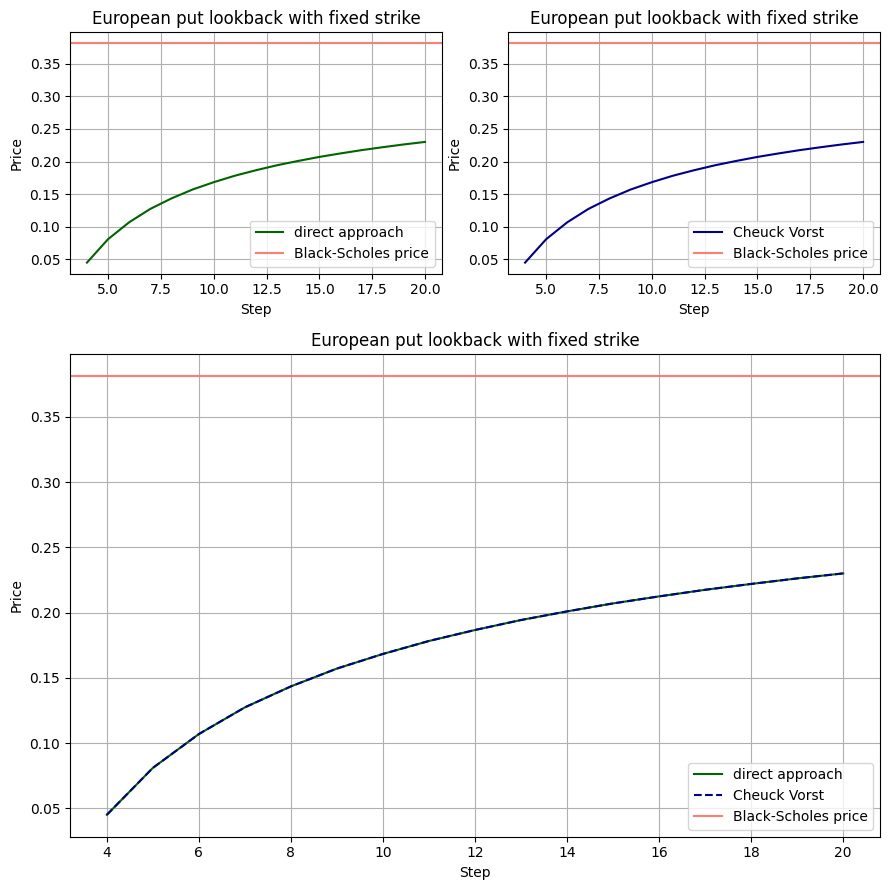

In [10]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :2])

ax1.plot(steps[:17], put_fixed, label = 'direct approach', color = 'darkgreen')
ax1.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], put_CV_fixed[:17], label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax3.plot(steps[:17], put_fixed, label = 'direct approach', color = 'darkgreen')
ax3.plot(steps[:17], put_CV_fixed[:17], linestyle = '--', label = 'Cheuck Vorst', color = 'darkblue')
ax3.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax3.set_ylabel('Price')
ax3.set_xlabel('Step')
ax3.grid()
ax3.legend(loc = 'lower right')

ax1.set_title('European put lookback with fixed strike')
ax2.set_title('European put lookback with fixed strike')
ax3.set_title('European put lookback with fixed strike')

plt.tight_layout()
plt.show()

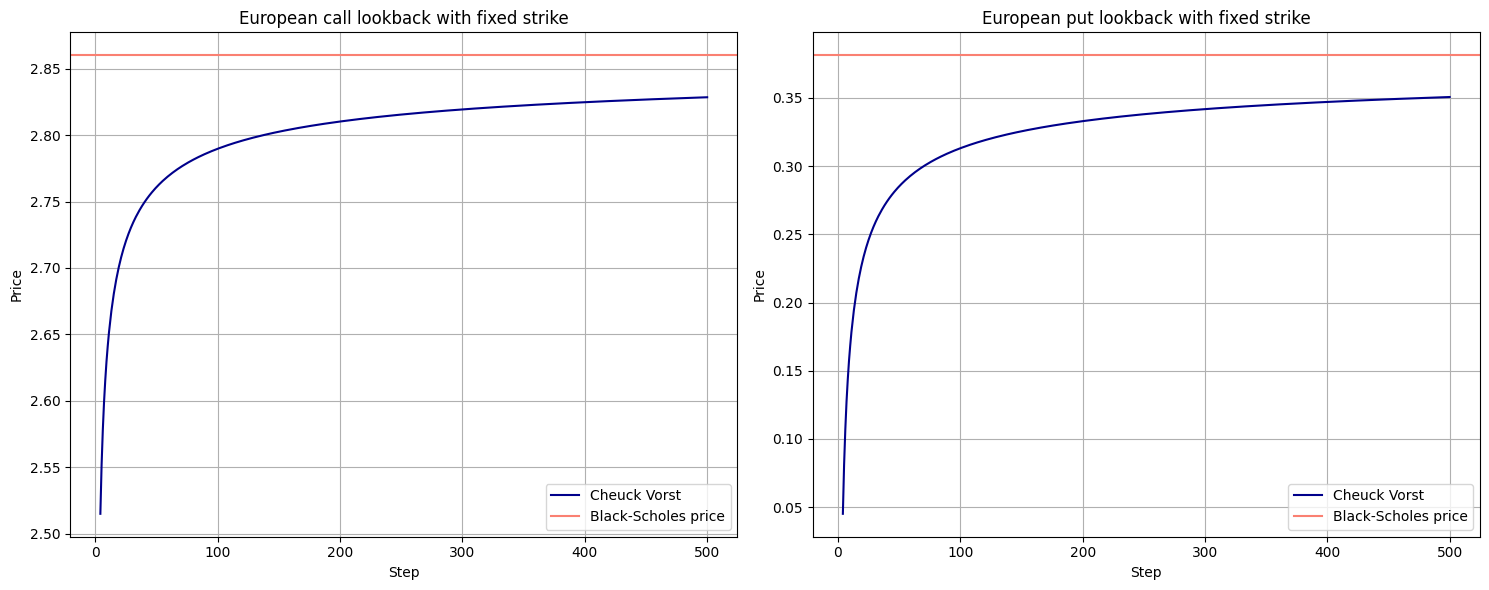

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(steps, call_CV_fixed, label = 'Cheuck Vorst', color = 'darkblue')
ax1.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps, put_CV_fixed, label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax1.set_title('European call lookback with fixed strike')
ax2.set_title('European put lookback with fixed strike')

plt.tight_layout()
plt.show()

Compare

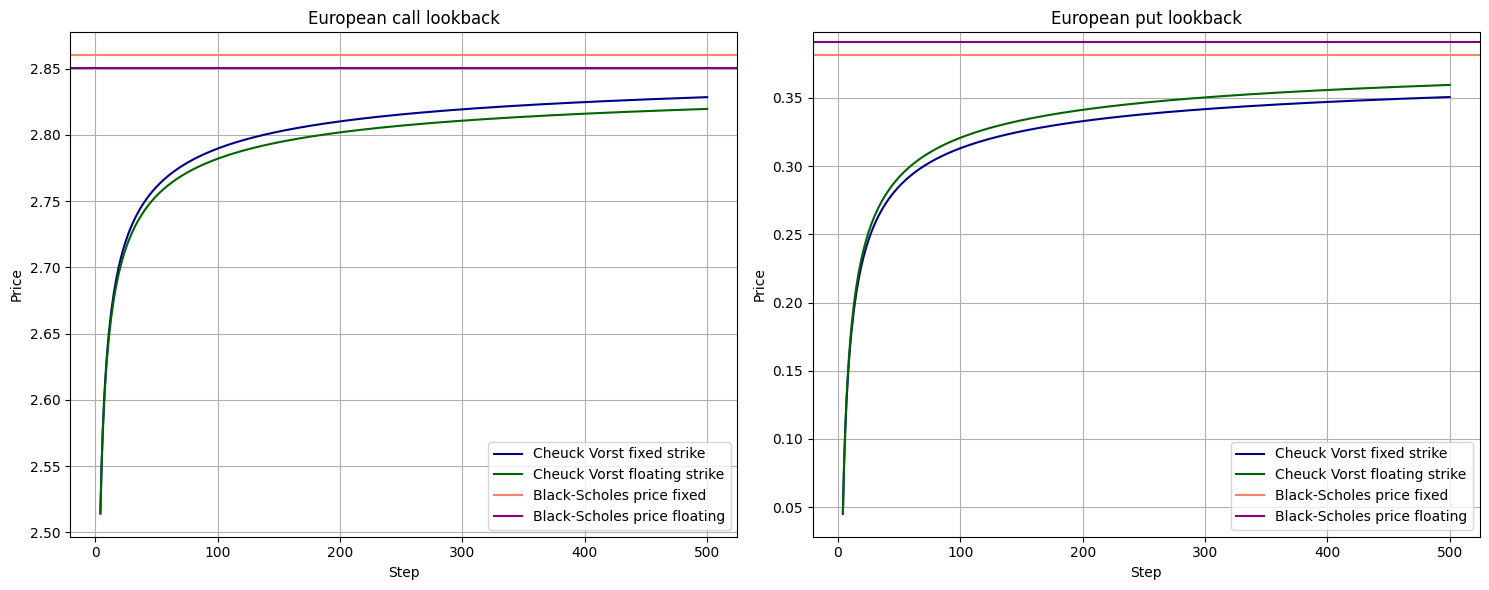

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(steps, call_CV_fixed, label = 'Cheuck Vorst fixed strike', color = 'darkblue')
ax1.plot(steps, call_CV_floating, label = 'Cheuck Vorst floating strike', color = 'darkgreen')
ax1.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price fixed')
ax1.axhline(bs_price_call_floating, color = 'purple', label = 'Black-Scholes price floating')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps, put_CV_fixed, label = 'Cheuck Vorst fixed strike', color = 'darkblue')
ax2.plot(steps, put_CV_floating, label = 'Cheuck Vorst floating strike', color = 'darkgreen')
ax2.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price fixed')
ax2.axhline(bs_price_put_floating, color = 'purple', label = 'Black-Scholes price floating')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax1.set_title('European call lookback')
ax2.set_title('European put lookback')

plt.tight_layout()
plt.show()

3. MC

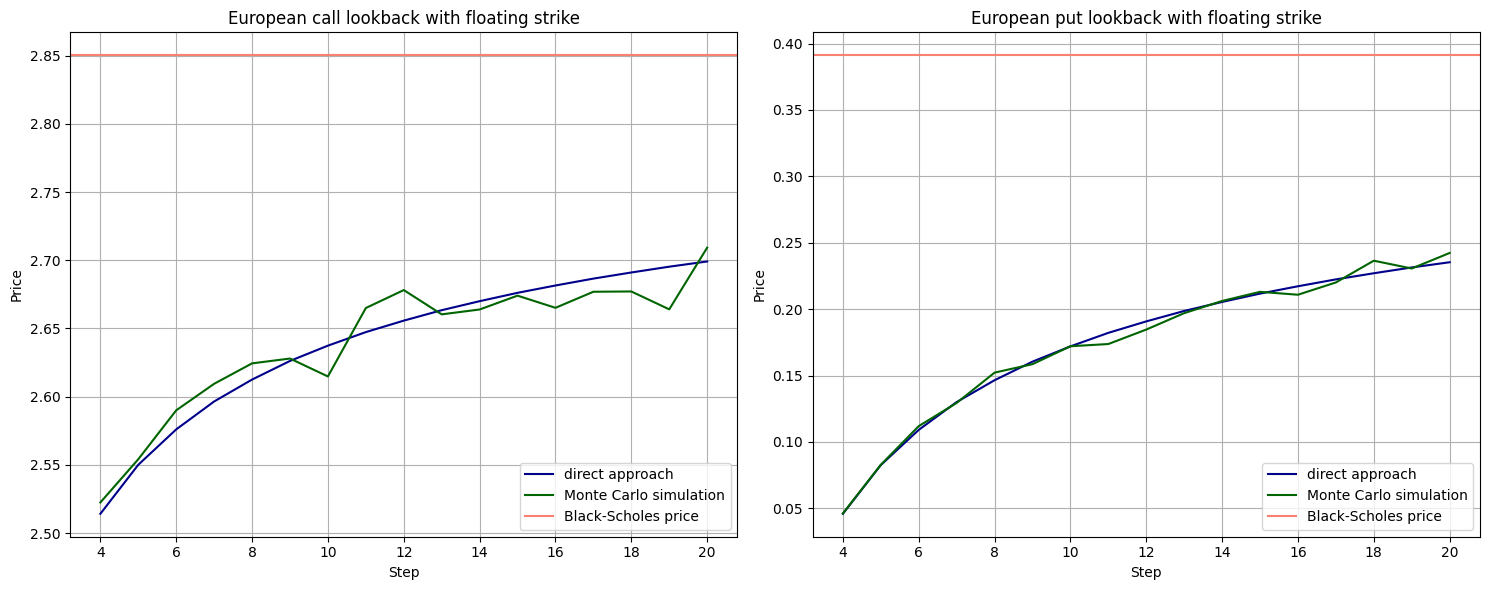

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(steps[:17], call_floating, label = 'direct approach', color = 'darkblue')
ax1.plot(steps[:17], call_simulate_floating, label = 'Monte Carlo simulation', color = 'darkgreen')
ax1.axhline(bs_price_call_floating, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], put_floating, label = 'direct approach', color = 'darkblue')
ax2.plot(steps[:17], put_simulate_floating, label = 'Monte Carlo simulation', color = 'darkgreen')
ax2.axhline(bs_price_put_floating, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax1.set_title('European call lookback with floating strike')
ax2.set_title('European put lookback with floating strike')

plt.tight_layout()
plt.show()

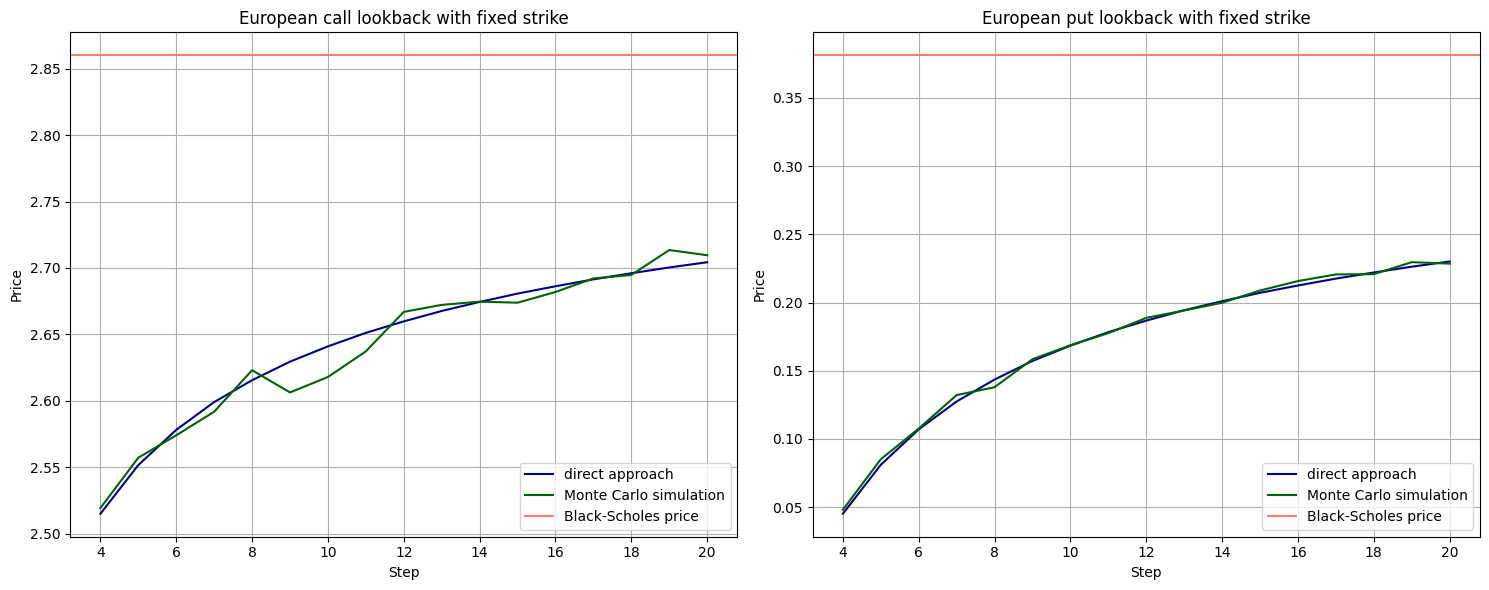

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(steps[:17], call_fixed, label = 'direct approach', color = 'darkblue')
ax1.plot(steps[:17], call_simulate_fixed, label = 'Monte Carlo simulation', color = 'darkgreen')
ax1.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], put_fixed, label = 'direct approach', color = 'darkblue')
ax2.plot(steps[:17], put_simulate_fixed, label = 'Monte Carlo simulation', color = 'darkgreen')
ax2.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax1.set_title('European call lookback with fixed strike')
ax2.set_title('European put lookback with fixed strike')

plt.tight_layout()
plt.show()

Other strike for fixed

In [15]:
S0 = 100
sigma = 0.02
r = 0.05
T = 0.5
K = 90

In [16]:
steps = np.arange(4, 501, 1)
put_fixed = []
call_fixed = []
call_CV_fixed = []
put_CV_fixed = []
for step in steps:
    lb = Lookback_options(S0, r, sigma, T, step, K)
    if step <= 20:
        call_fixed.append(lb.calculate_price('call', 'fixed'))
        put_fixed.append(lb.calculate_price('put', 'fixed'))
    call_CV_fixed.append(lb.calculate_price_Cheuk_Vorst('call', 'fixed'))
    put_CV_fixed.append(lb.calculate_price_Cheuk_Vorst('put', 'fixed'))

In [17]:
bs_price_call_fixed = lb.price('call', S0, 0, 'fixed')
bs_price_put_fixed = lb.price('put', S0, 0, 'fixed')

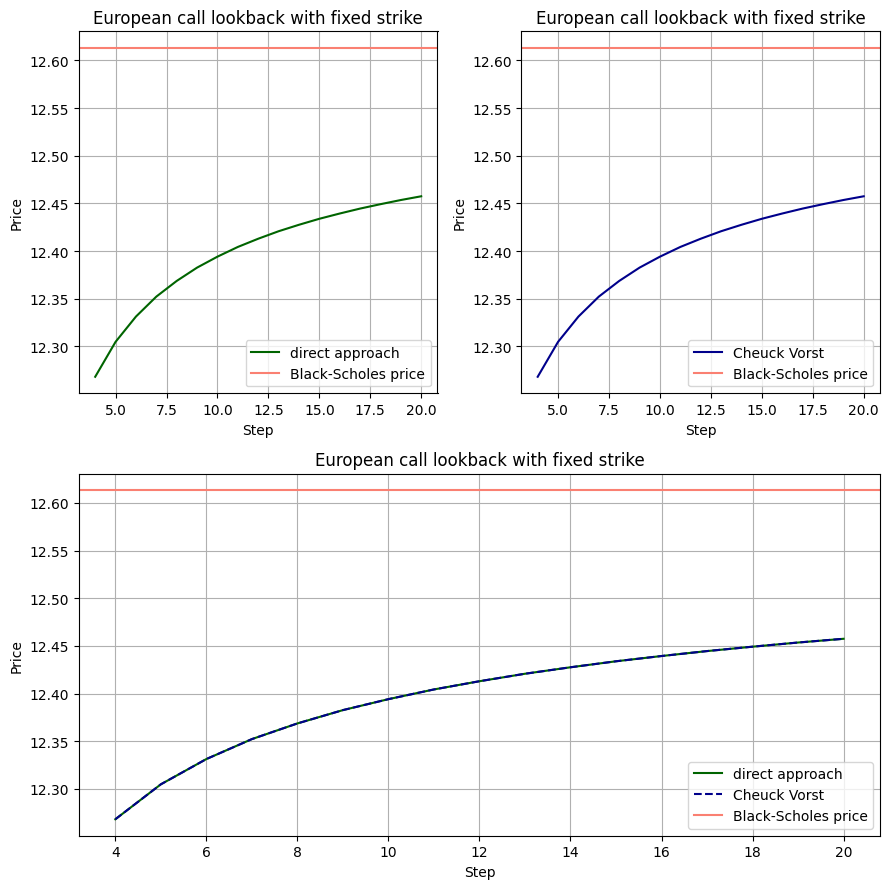

In [18]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :2])

ax1.plot(steps[:17], call_fixed, label = 'direct approach', color = 'darkgreen')
ax1.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], call_CV_fixed[:17], label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax3.plot(steps[:17], call_fixed, label = 'direct approach', color = 'darkgreen')
ax3.plot(steps[:17], call_CV_fixed[:17], linestyle = '--', label = 'Cheuck Vorst', color = 'darkblue')
ax3.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax3.set_ylabel('Price')
ax3.set_xlabel('Step')
ax3.grid()
ax3.legend(loc = 'lower right')

ax1.set_title('European call lookback with fixed strike')
ax2.set_title('European call lookback with fixed strike')
ax3.set_title('European call lookback with fixed strike')

plt.tight_layout()
plt.show()

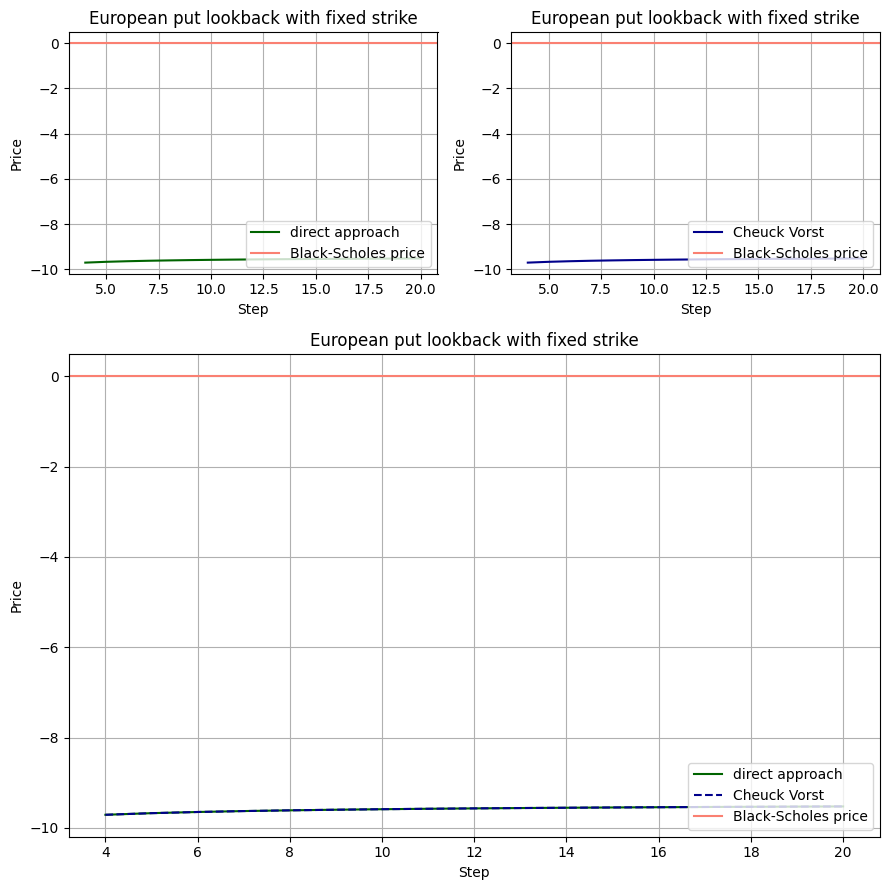

In [19]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :2])

ax1.plot(steps[:17], put_fixed, label = 'direct approach', color = 'darkgreen')
ax1.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], put_CV_fixed[:17], label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax3.plot(steps[:17], put_fixed, label = 'direct approach', color = 'darkgreen')
ax3.plot(steps[:17], put_CV_fixed[:17], linestyle = '--', label = 'Cheuck Vorst', color = 'darkblue')
ax3.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax3.set_ylabel('Price')
ax3.set_xlabel('Step')
ax3.grid()
ax3.legend(loc = 'lower right')

ax1.set_title('European put lookback with fixed strike')
ax2.set_title('European put lookback with fixed strike')
ax3.set_title('European put lookback with fixed strike')

plt.tight_layout()
plt.show()

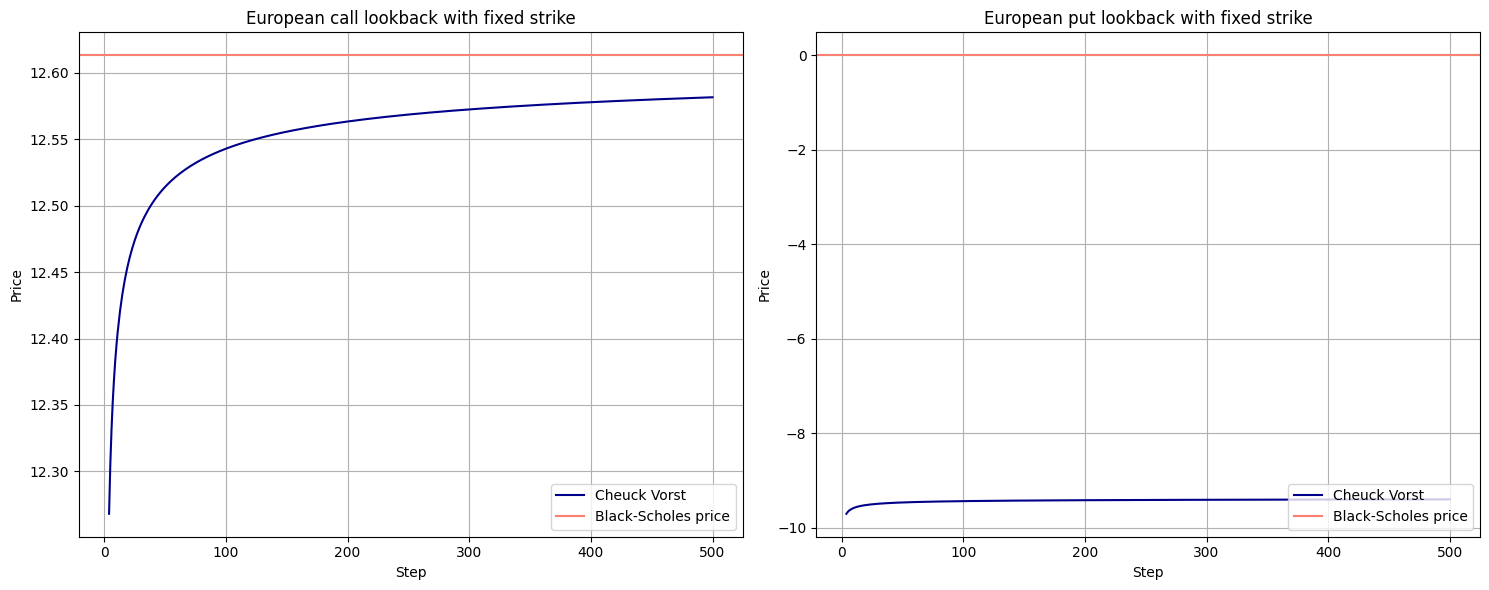

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(steps, call_CV_fixed, label = 'Cheuck Vorst', color = 'darkblue')
ax1.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps, put_CV_fixed, label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax1.set_title('European call lookback with fixed strike')
ax2.set_title('European put lookback with fixed strike')

plt.tight_layout()
plt.show()

In [21]:
S0 = 100
sigma = 0.02
r = 0.05
T = 0.5
K = 110

In [22]:
steps = np.arange(4, 501, 1)
put_fixed = []
call_fixed = []
call_CV_fixed = []
put_CV_fixed = []
for step in steps:
    lb = Lookback_options(S0, r, sigma, T, step, K)
    if step <= 20:
        call_fixed.append(lb.calculate_price('call', 'fixed'))
        put_fixed.append(lb.calculate_price('put', 'fixed'))
    call_CV_fixed.append(lb.calculate_price_Cheuk_Vorst('call', 'fixed'))
    put_CV_fixed.append(lb.calculate_price_Cheuk_Vorst('put', 'fixed'))

In [23]:
bs_price_call_fixed = lb.price('call', S0, 0, 'fixed')
bs_price_put_fixed = lb.price('put', S0, 0, 'fixed')

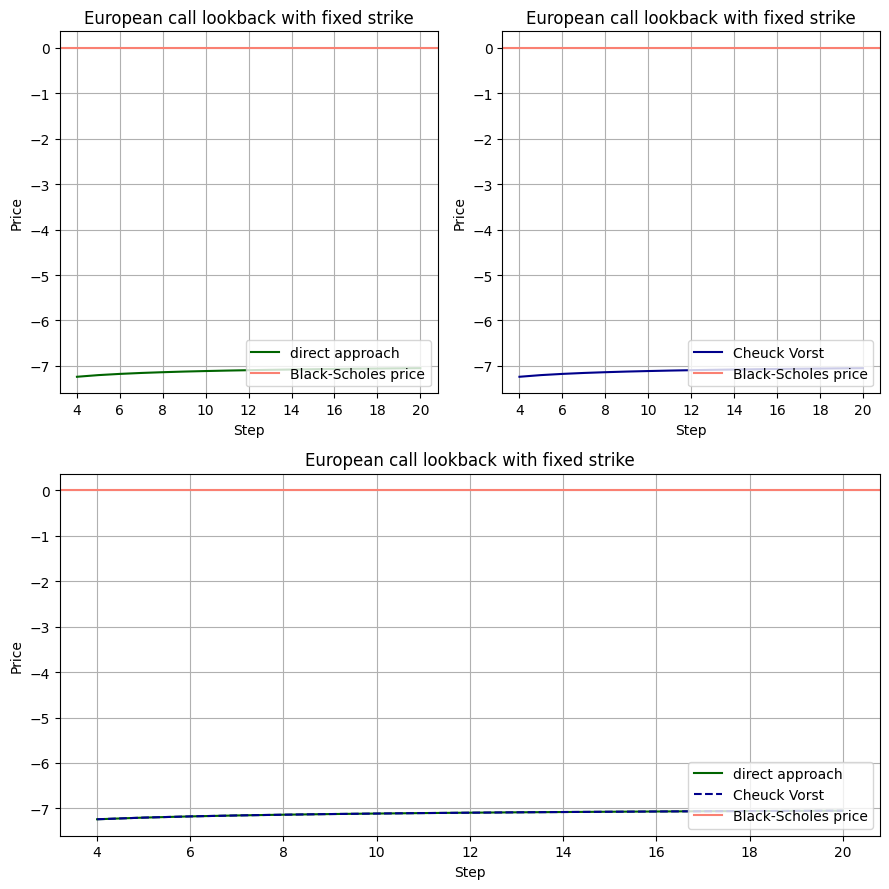

In [24]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :2])

ax1.plot(steps[:17], call_fixed, label = 'direct approach', color = 'darkgreen')
ax1.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], call_CV_fixed[:17], label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax3.plot(steps[:17], call_fixed, label = 'direct approach', color = 'darkgreen')
ax3.plot(steps[:17], call_CV_fixed[:17], linestyle = '--', label = 'Cheuck Vorst', color = 'darkblue')
ax3.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax3.set_ylabel('Price')
ax3.set_xlabel('Step')
ax3.grid()
ax3.legend(loc = 'lower right')

ax1.set_title('European call lookback with fixed strike')
ax2.set_title('European call lookback with fixed strike')
ax3.set_title('European call lookback with fixed strike')

plt.tight_layout()
plt.show()

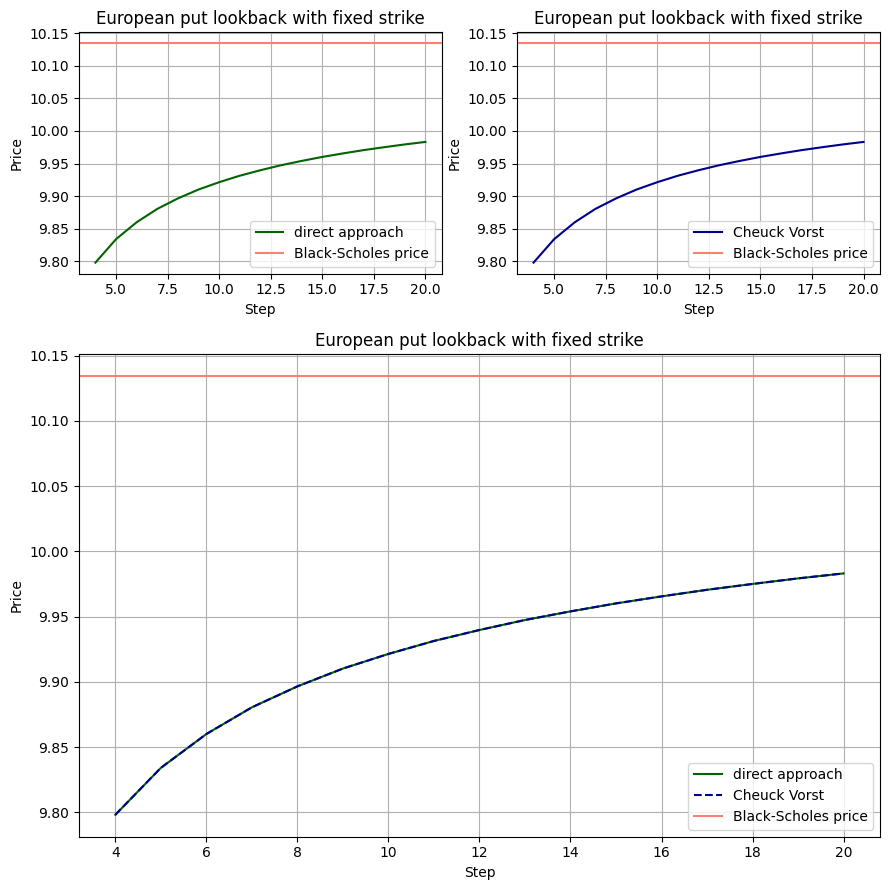

In [25]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :2])

ax1.plot(steps[:17], put_fixed, label = 'direct approach', color = 'darkgreen')
ax1.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps[:17], put_CV_fixed[:17], label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax3.plot(steps[:17], put_fixed, label = 'direct approach', color = 'darkgreen')
ax3.plot(steps[:17], put_CV_fixed[:17], linestyle = '--', label = 'Cheuck Vorst', color = 'darkblue')
ax3.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax3.set_ylabel('Price')
ax3.set_xlabel('Step')
ax3.grid()
ax3.legend(loc = 'lower right')

ax1.set_title('European put lookback with fixed strike')
ax2.set_title('European put lookback with fixed strike')
ax3.set_title('European put lookback with fixed strike')

plt.tight_layout()
plt.show()

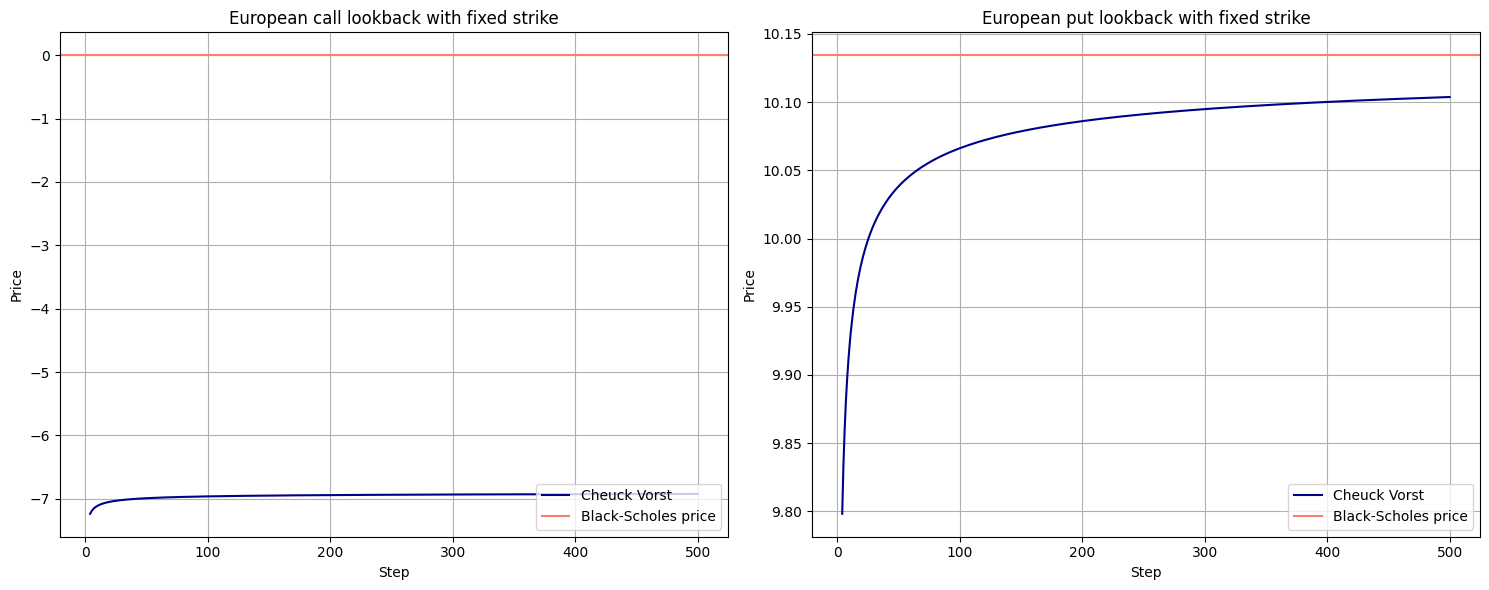

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(steps, call_CV_fixed, label = 'Cheuck Vorst', color = 'darkblue')
ax1.axhline(bs_price_call_fixed, color = 'salmon', label = 'Black-Scholes price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Step')
ax1.grid()
ax1.legend(loc = 'lower right')

ax2.plot(steps, put_CV_fixed, label = 'Cheuck Vorst', color = 'darkblue')
ax2.axhline(bs_price_put_fixed, color = 'salmon', label = 'Black-Scholes price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Step')
ax2.grid()
ax2.legend(loc = 'lower right')

ax1.set_title('European call lookback with fixed strike')
ax2.set_title('European put lookback with fixed strike')

plt.tight_layout()
plt.show()